# Result Analysis

In [1]:
import RNNJF
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as plt3d

import pandas as pd
import math
import copy
import pickle
from keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.layers import BatchNormalization, Layer, TimeDistributed, Dropout
from keras.layers import Dense, Input, Masking, LSTM
from sklearn.preprocessing import MinMaxScaler, RobustScaler

from sklearn.metrics import mean_squared_error

C:\Users\Greg\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Greg\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Greg\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Greg\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:5

In [3]:
def load_data(DF, remove_dirtrack, add_dirtrack, features=['d0', 'z0', 'phi', 'theta', 'q/p']):
    order_by_feature = None
    use_custom_order = 't1'
    reverse=True
    no_reorder=False
    all_features = np.array(['d0', 'z0', 'phi', 'theta', 'q/p', 'x_o', 'y_o', 'z_o', 'x_p', 'y_p', 'z_p'])
    print("reading the datafile")
    bjets_DF = pd.read_pickle(DF)  # "./bjets_IPonly_abs_10um_errs.pkl")
    print("loading tracks")
    X = RNNJF.get_tracks(bjets_DF)
    print("preprocessing the data")
    if remove_dirtrack: X = RNNJF.remove_direction_track(X, len(features))
    nodirtrack = remove_dirtrack or not add_dirtrack
    if order_by_feature is not None:
        if reverse:
            print("ordering by decreasing {}".format(order_by_feature))
        else:
            print("ordering by increasing {}".format(order_by_feature))
        fidx = np.where(all_features == order_by_feature)[0][0]
        X = RNNJF.order_by_feature(X, nodirtrack, reverse, feature=fidx)
    elif use_custom_order is not None:
        if use_custom_order == 'r0':
            print("using custom ordering: by sqrt(d0^2 +z0^2)")
            X = RNNJF.order_by_r0(X, nodirtrack, reverse)
        elif use_custom_order == 't1':
            print("using custom ordering: by t1")
            X = RNNJF.order_by_t1(X, nodirtrack, reverse)
        else:
            raise NotImplemented("custom ordering with {} not implemented".format(args.use_custom_order))
    elif no_reorder:
        print("No reorder performed")
    else:
        print("using random order")
        X = RNNJF.order_random(X)
    
    X_allfeatures = copy.copy(X)
    X = RNNJF.only_keep_features(X, features)
    robust_features=['d0','z0','q/p','x_p','y_p']
    X = RNNJF.scale_features(X, features, robust_features=robust_features)
    X = np.nan_to_num(X)
    y = bjets_DF[['secVtx_x', 'secVtx_y', 'secVtx_z', 'terVtx_x', 'terVtx_y', 'terVtx_z']].values
    y = y * 1000  # change units of vertices from m to mm, keep vals close to unity
    return X, y, X_allfeatures


In [ ]:
datafile = "./bjets_newminerrs.pkl"

In [4]:
order_by_feature = None
use_custom_order = 't1'
reverse=True
no_reorder=False
if "new" in datafile:
    remove_dirtrack = False
    # option to add dirtrack using jet information
    add_dirtrack = False
else:
    remove_dirtrack = True
    # add_dirtrack = False

features = ['d0', 'z0', 'phi', 'theta', 'q/p','x_p','y_p']

# use custom load data here to extract X_allfeatures (needed for jet drawings)
X, y, X_allfeatures = load_data(datafile,remove_dirtrack,add_dirtrack,features=features)
# X, y = RNNJF.load_data(datafile,remove_dirtrack,add_dirtrack,features=features,order_by_feature=order_by_feature,
#                                                   use_custom_order=use_custom_order, reverse=reverse,
#                                                   no_reorder=no_reorder)
X_train, X_test, y_train, y_test = RNNJF.split_train_test(X, y,split=280000, seed=4)

reading the datafile
loading tracks
preprocessing the data
using custom ordering: by t1
no direction track, ordering by closest distance along jet axis
Robust Scaling: d0
Robust Scaling: z0
MinMax Scaling: phi
MinMax Scaling: theta
Robust Scaling: q/p
Robust Scaling: x_p
Robust Scaling: y_p
train/test split with seed 4
(280000, 30, 7)


In [4]:
bjets_DF = pd.read_pickle(datafile)  # "./bjets_IPonly_abs_10um_errs.pkl")
# y_test=np.load("./y_test.npy")
# X_test=np.load("./X_test.npy")

In [5]:
# Select number of hidden and dense layers. Initially use same as RNNIP but these can be tuned going forward.

nHidden = 300
nDense = 40

In [6]:
nJets, nTrks, nFeatures = X_test.shape
nOutputs = y.shape[1] # ie sec and ter vtx xyz, so 6

In [7]:
trk_inputs = Input(shape=(nTrks,nFeatures),name="Trk_inputs")
masked_input = Masking()(trk_inputs)

# Feed this merged layer to an RNN
lstm = LSTM(nHidden, return_sequences=False, name='LSTM')(masked_input)
dpt = Dropout(rate=0.2)(lstm) # this is a very high dropout rate, reduce it

my_inputs = trk_inputs

# Fully connected layer: This will convert the output of the RNN to our vtx postion predicitons
FC = Dense(nDense, activation='relu', name="Dense")(dpt) # is relu fine here? i think so...

# Ouptut layer. Sec and Ter Vtx. No activation as this is a regression problem
output = Dense(nOutputs, name="Vertex_Predictions")(FC)

myRNN = Model(inputs=my_inputs, outputs=output)


In [8]:
myRNN.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Trk_inputs (InputLayer)      [(None, 30, 7)]           0         
_________________________________________________________________
masking (Masking)            (None, 30, 7)             0         
_________________________________________________________________
LSTM (LSTM)                  (None, 300)               369600    
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
Dense (Dense)                (None, 40)                12040     
_________________________________________________________________
Vertex_Predictions (Dense)   (None, 6)                 246       
Total params: 381,886
Trainable params: 381,886
Non-trainable params: 0
_______________________________________________________

In [9]:
myRNN.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae','mse']) # do i want to add a metric like mse to evaluate during training
# myRNN.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae','mse']) # do i want to add a metric like mse to evaluate during training


In [10]:
# load model
myRNN.load_weights('./bestRNN.h5')


Use the RNN now to predict the vertices of a test sample X_test. This is essentially 20000 jets, each jet consisting of its track collection (the first track in the collection is an artificial one consisting of the measured jet direction)

In [11]:
%%time
results=myRNN.predict(X_test)
results

Wall time: 20.5 s


array([[1.4857343 , 1.4862646 , 2.104029  , 1.7463042 , 1.740516  ,
        2.4720626 ],
       [1.5853068 , 1.5856559 , 2.2441018 , 1.8585669 , 1.9306494 ,
        2.6419601 ],
       [1.4931606 , 1.4938701 , 2.1149027 , 2.0120773 , 1.7698807 ,
        2.8708382 ],
       ...,
       [2.375138  , 2.3751917 , 3.360962  , 3.7921944 , 3.6204538 ,
        5.1514063 ],
       [0.29586148, 0.29628602, 0.41901588, 1.437701  , 1.3709806 ,
        1.2122166 ],
       [0.25751218, 0.25766087, 0.3642787 , 0.7288151 , 0.7197899 ,
        0.85807943]], dtype=float32)

In [12]:
%%time
Xrando=copy.copy(X_test)
for i in range(len(X_test)):
    null_ind=np.where(Xrando[i]==0.)[0][0]
    np.random.shuffle(Xrando[i][0:null_ind])
results2 = myRNN.predict(Xrando)
percentage_errs2=(abs((results2-y_test)/y_test)*100) # average error of 50%, so for vtx at 1mm, we get within 0.5mm
mean_abs_errs2 = abs((results2-y_test))
mae_per_jet2 = np.mean(mean_abs_errs2,axis=1)
print(np.median(mae_per_jet2)) 
print(np.mean(mae_per_jet2))

0.3865202071672573
0.7588124788941618
Wall time: 22.8 s


In [13]:
percentage_errs=(abs((results-y_test)/y_test)*100) # average error of 50%, so for vtx at 1mm, we get within 0.5mm
mean_abs_errs = abs((results-y_test))
mae_per_jet = np.mean(mean_abs_errs,axis=1)
square_errs= (results - y_test)**2
rms_errs = np.sqrt(square_errs)
mse_per_jet= np.mean(square_errs,axis=1)
rms_per_jet= np.mean(rms_errs,axis=1)
mpe_per_jet=np.mean(percentage_errs,axis=1)

In [14]:
print(np.median(mae_per_jet)) 
print(np.mean(mae_per_jet))
print(np.median(mpe_per_jet)) 
print(np.mean(mpe_per_jet))
print(np.max(mae_per_jet))


0.06431171933156808
0.11804502152656114
3.8646948663777474
32.352358609819916
5.112002781717897


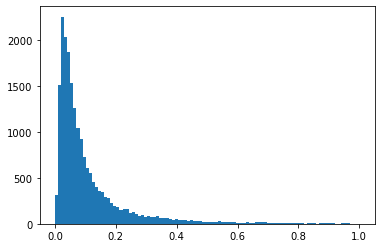

In [15]:
plt.hist(mae_per_jet,bins=np.linspace(0,1,100))
plt.show()
#plt.hist(mae_per_jet2,bins='scott')
#plt.show()

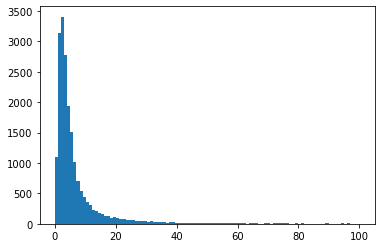

In [16]:
plt.hist(np.mean(percentage_errs,axis=1),bins=np.linspace(0,100,100))
plt.show()

In [27]:
def describe_helper(series,ndp="{0:.2f}"):
    splits = str(series.describe().apply(ndp.format)).split()
    keys, values = "", ""
    for i in range(0, len(splits), 2):
        if splits[i] == "dtype:":
            continue
        keys += "{:8}\n".format(splits[i])
        values += "{:>8}\n".format(splits[i+1])
    return keys, values

In [22]:
percentage_errs

array([[ 0.81772329,  0.78232618,  0.68162115,  1.38927404,  3.12238725,
         3.27653682],
       [ 2.19557554,  2.17403411,  2.10224373,  3.35016914,  3.14628997,
         3.87683459],
       [ 6.13122066,  6.18165307,  6.29480437,  0.99070629,  2.96427332,
         6.17040453],
       ...,
       [ 5.47531122,  5.47769345,  5.53841138,  1.41101526,  0.14763564,
         0.68260316],
       [11.59665071, 11.75678166, 11.75789686,  8.57884568,  6.01943852,
        26.02977062],
       [17.09590053, 17.16351   , 17.12853113,  5.92264035,  2.07807985,
         5.6045116 ]])

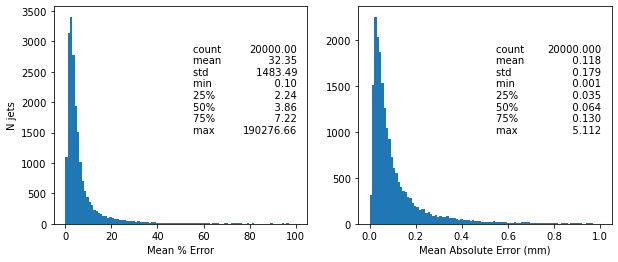

In [39]:
fig, axs = plt.subplots(1,2,figsize=(10,4))

axs[0].hist(np.mean(percentage_errs,axis=1),np.linspace(0,100,100))
axs[0].set_xlabel('Mean % Error')
axs[0].set_ylabel('N jets')
# axs[0].figtext(.66, .4, describe_helper(pd.Series(np.mean(percentage_errs,axis=1))[0], {'multialignment':'left'})
# axs[0].figtext(.75, .4, describe_helper(pd.Series(np.mean(percentage_errs,axis=1))[1], {'multialignment':'right'})


axs[1].hist(mae_per_jet,bins=np.linspace(0,1,100))
axs[1].set_xlabel('Mean Absolute Error (mm)')
axs[0].set_ylabel('N jets')


plt.figtext(.74, .4, describe_helper(pd.Series(mae_per_jet),ndp="{0:.3f}")[0], {'multialignment':'left'})
plt.figtext(.81, .4, describe_helper(pd.Series(mae_per_jet),ndp="{0:.3f}")[1], {'multialignment':'right'})

plt.figtext(.318, .4, describe_helper(pd.Series(np.mean(percentage_errs,axis=1)))[0], {'multialignment':'left'})
plt.figtext(.388, .4, describe_helper(pd.Series(np.mean(percentage_errs,axis=1)))[1], {'multialignment':'right'})


plt.savefig('RNNJF-mae-mpe-per-jet')

### Vertexing Efficiency

First calculate the distance between the reconstructed and true vertex. Maybe plot this (gives an idea of error).

Then come up with some value using the error propagation for single track and jet axis. Obviously challenging problem.



In [40]:
vertex_distances=np.linalg.norm(((results - y_test)).reshape(20000,2,3),axis=2)

In [41]:
def print_values(vertex_distances,sdmin):
    n1found = np.sum(vertex_distances.reshape(-1) < sdmin)
    n2found = np.sum(vertex_distances.reshape(-1) < 2*sdmin)
    n5found = np.sum(vertex_distances.reshape(-1) < 5*sdmin)
    print("% of vertices found for n=1: {}% ({})".format(n1found/400,n1found))    
    print("% of vertices found for n=2: {}% ({})".format(n2found/400,n2found))
    print("% of vertices found for n=5: {}% ({})".format(n5found/400,n5found))
    n1jet2vtx=np.sum(np.sum(vertex_distances < sdmin,axis=1) == 2)/200
    n1jet1vtx=np.sum(np.sum(vertex_distances < sdmin,axis=1) == 1)/200
    n1jet0vtx=np.sum(np.sum(vertex_distances < sdmin,axis=1) == 0)/200
    
    n2jet2vtx=np.sum(np.sum(vertex_distances < 2*sdmin,axis=1) == 2)/200
    n2jet1vtx=np.sum(np.sum(vertex_distances < 2*sdmin,axis=1) == 1)/200
    n2jet0vtx=np.sum(np.sum(vertex_distances < 2*sdmin,axis=1) == 0)/200    
    
    n5jet2vtx=np.sum(np.sum(vertex_distances < 5*sdmin,axis=1) == 2)/200
    n5jet1vtx=np.sum(np.sum(vertex_distances < 5*sdmin,axis=1) == 1)/200
    n5jet0vtx=np.sum(np.sum(vertex_distances < 5*sdmin,axis=1) == 0)/200
    print("n=1: {}% have both found, {}% have 1 found, {}% have 0".format(n1jet2vtx,n1jet1vtx,n1jet0vtx))
    print("n=2: {}% have both found, {}% have 1 found, {}% have 0".format(n2jet2vtx,n2jet1vtx,n2jet0vtx))
    print("n=5: {}% have both found, {}% have 1 found, {}% have 0".format(n5jet2vtx,n5jet1vtx,n5jet0vtx))

In [42]:
print("for max sdmin")
print_values(vertex_distances,2.47)
print()
print("for median sdmin")
print_values(vertex_distances,.058)


for max sdmin
% of vertices found for n=1: 99.5675% (39827)
% of vertices found for n=2: 99.9275% (39971)
% of vertices found for n=5: 99.995% (39998)
n=1: 99.2% have both found, 0.735% have 1 found, 0.065% have 0
n=2: 99.855% have both found, 0.145% have 1 found, 0.0% have 0
n=5: 99.99% have both found, 0.01% have 1 found, 0.0% have 0

for median sdmin
% of vertices found for n=1: 30.305% (12122)
% of vertices found for n=2: 53.9125% (21565)
% of vertices found for n=5: 81.27% (32508)
n=1: 11.155% have both found, 38.3% have 1 found, 50.545% have 0
n=2: 34.395% have both found, 39.035% have 1 found, 26.57% have 0
n=5: 70.16% have both found, 22.22% have 1 found, 7.62% have 0


In [43]:
sdmin=1.540
np.sum(np.sum(vertex_distances < 5*sdmin,axis=1) == 1)

8

In [44]:
2/200

0.01

In [45]:
17/200

0.085

As an initial estimate 1621/40000 (4%) vertices found using a criteria that distance must be less than $10\mu m$
(this is a vast underestimate)

In [46]:
print(np.sum(np.sum(vertex_distances < 0.01,axis=1) == 2)/20000)
print(np.sum(np.sum(vertex_distances < 0.01,axis=1) == 1)/20000)
print(np.sum(np.sum(vertex_distances < 0.01,axis=1) == 0)/20000)

0.00055
0.07995
0.9195


Around 0.5% have both vertices found, 8% have only one found vertex and 92% have no found vertices

In [47]:
print(np.sum(vertex_distances.reshape(-1) < 0.05)/40000)
print(np.sum(np.sum(vertex_distances < 0.05,axis=1) == 2)/20000)
print(np.sum(np.sum(vertex_distances < 0.05,axis=1) == 1)/20000)
print(np.sum(np.sum(vertex_distances < 0.05,axis=1) == 0)/20000)

0.261475
0.0817
0.35955
0.55875


If we increase this criteria to less than $50\mu m$, then 26% of vertices are found. 8% of events have both vertices found and 44% of events have at least one.

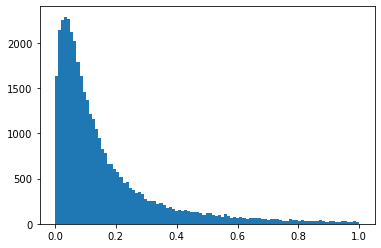

In [48]:
plt.hist(vertex_distances.reshape(-1),bins=np.linspace(0,1,100))
plt.show()

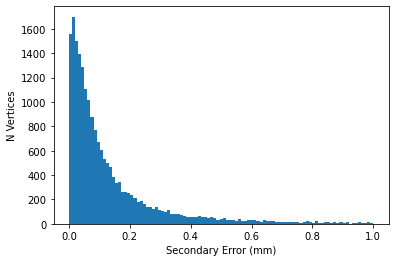

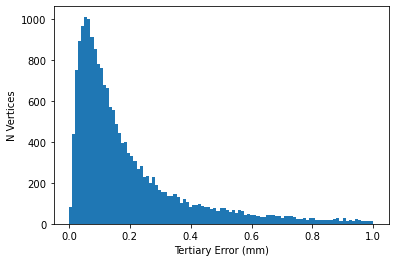

In [49]:
plt.hist(vertex_distances[:,0],bins=np.linspace(0,1,100))
plt.ylabel("N Vertices")
plt.xlabel("Secondary Error (mm)")
plt.show()
plt.hist(vertex_distances[:,1],bins=np.linspace(0,1,100))
plt.ylabel("N Vertices")
plt.xlabel("Tertiary Error (mm)")
plt.show()

In [50]:
print(np.mean(vertex_distances[:,0]))
print(np.mean(vertex_distances[:,1]))
print(np.median(vertex_distances[:,0]))
print(np.median(vertex_distances[:,1]))

0.16026937284692572
0.2661055716775606
0.0755301092923491
0.13474910774123047


In [51]:
true_vtx_distance_from_origin=np.linalg.norm(((y_test)).reshape(20000,2,3),axis=2)

In [52]:
percentage_vertex_errors=(vertex_distances/true_vtx_distance_from_origin)*100

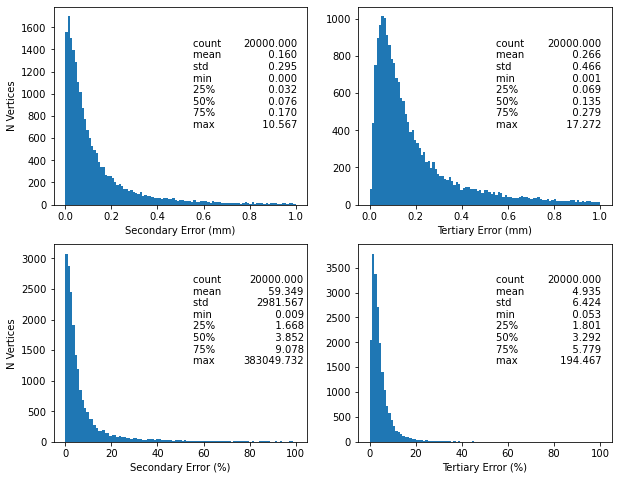

In [66]:
fig, axs = plt.subplots(2,2,figsize=(10,8))

axs[0, 0].hist(vertex_distances[:,0],bins=np.linspace(0,1,100))
axs[0, 0].set_ylabel("N Vertices")
axs[0, 0].set_xlabel("Secondary Error (mm)")

axs[0, 1].hist(vertex_distances[:,1],bins=np.linspace(0,1,100))
axs[0, 1].set_xlabel("Tertiary Error (mm)")

axs[1, 0].hist(percentage_vertex_errors[:,0],bins=np.linspace(0,100,100))
axs[1, 0].set_ylabel("N Vertices")
axs[1, 0].set_xlabel("Secondary Error (%)")

axs[1, 1].hist(percentage_vertex_errors[:,1],bins=np.linspace(0,100,100))
axs[1, 1].set_xlabel("Tertiary Error (%)")

plt.figtext(.74, .65, describe_helper(pd.Series(vertex_distances[:,1]),ndp="{0:.3f}")[0], {'multialignment':'left'})
plt.figtext(.81, .65, describe_helper(pd.Series(vertex_distances[:,1]),ndp="{0:.3f}")[1], {'multialignment':'right'})

plt.figtext(.318, .65, describe_helper(pd.Series(vertex_distances[:,0]),ndp="{0:.3f}")[0], {'multialignment':'left'})
plt.figtext(.388, .65, describe_helper(pd.Series(vertex_distances[:,0]),ndp="{0:.3f}")[1], {'multialignment':'right'})

plt.figtext(.74, .24, describe_helper(pd.Series(percentage_vertex_errors[:,1]),ndp="{0:.3f}")[0], {'multialignment':'left'})
plt.figtext(.81, .24, describe_helper(pd.Series(percentage_vertex_errors[:,1]),ndp="{0:.3f}")[1], {'multialignment':'right'})

plt.figtext(.318, .24, describe_helper(pd.Series(percentage_vertex_errors[:,0]),ndp="{0:.3f}")[0], {'multialignment':'left'})
plt.figtext(.388, .24, describe_helper(pd.Series(percentage_vertex_errors[:,0]),ndp="{0:.3f}")[1], {'multialignment':'right'})


plt.savefig('RNNJF-sec-ter-vtx-error.png')

In [73]:
print(np.mean(percentage_vertex_errors[:,0]))
print(np.mean(percentage_vertex_errors[:,1]))
print(np.median(percentage_vertex_errors[:,0]))
print(np.median(percentage_vertex_errors[:,1]))

59.34907428222364
4.935299156755294
3.8516124791939266
3.2920977382758343


In [74]:
np.max(percentage_vertex_errors[:,0])

383049.7316695234

In [75]:
y_test[1618]

array([3.80939685e-05, 3.80939685e-05, 5.38730068e-05, 6.06375048e+00,
       6.60532356e+00, 9.76202861e+00])

In [76]:
print(vertex_distances[1618,0])
print(vertex_distances[1618,1])

0.29183768797615356
0.2666661172011998


In [77]:
np.argmin(percentage_vertex_errors[:,1])

13568

In [78]:
print(percentage_vertex_errors[13568,0])
print(percentage_vertex_errors[13568,1])

0.46146367567984287
0.05268091889015005


In [79]:
print(vertex_distances[13568,0])
print(vertex_distances[13568,1])

0.09035749814631418
0.011158418802509222


In [80]:
y_test[13568]

array([ 9.79031535,  9.79031535, 13.84559675, 10.52291186, 10.68480993,
       14.95806886])

In [81]:
np.mean(true_vtx_distance_from_origin[:,0])

3.716249613428129

### Bad jet analysis

### Jet Drawings

Here we have the code to plot the images of jets. Useful for looking at particular bad jets.

In [82]:
t = np.linspace(-.004,.022,100)

def get_line_from_tp(track):
    p1 = track[5:8]
    print("particle origin is",p1)
    phi = track[2]
    theta = track[3]
    
    xs = p1[0] + t * np.sin(theta) * np.cos(phi)
    ys = p1[1] + t * np.sin(theta) * np.sin(phi)
    zs = p1[2] + t * np.cos(theta)
    
    return xs, ys, zs

def get_line_from_perigee(track):
    p1 = track[8:11]
#     print("particle perigee is",p1)
    phi = track[2]
    theta = track[3]
    
    xs = p1[0] + t * np.sin(theta) * np.cos(phi)
    ys = p1[1] + t * np.sin(theta) * np.sin(phi)
    zs = p1[2] + t * np.cos(theta)
    
    return xs, ys, zs

def get_line_using_IPs(track):
    phi = track[2]
    theta = track[3]
    x0 = track[0]*np.cos(phi)
    y0 = track[0]*np.sin(phi)
    z0 = track[1]
    p1 = np.array([x0,y0,z0])
#     print("particle point from IP is",p1)

    
    xs = p1[0] + t * np.sin(theta) * np.cos(phi)
    ys = p1[1] + t * np.sin(theta) * np.sin(phi)
    zs = p1[2] + t * np.cos(theta)
    
    return xs, ys, zs

def plot_direction(ax):
    theta = np.pi/4
    phi=np.pi/4
    xs = t * np.sin(theta) * np.cos(phi)
    ys = t * np.sin(theta) * np.sin(phi)
    zs = t * np.cos(theta)
#     xs,ys,zs= 2*xs,2*ys,2*zs
    ax.plot(xs,ys,zs,'--')


In [113]:

def plot_jet(jet_tracks, true_vertices, X_test, y_test, name):
#     jet_tracks, true_vertices, rec_vertices,[-0.0001,0.003],'bla'

    fig = plt.figure(figsize=(15,15))
    ax = fig.gca(projection='3d')
    
    plot_direction(ax)

    for i,track in enumerate(jet_tracks):
        if not np.isnan(track[0]):
#             xs, ys, zs = get_line_using_IPs(track)
#             xs, ys, zs = get_line_from_tp(track)
            xs, ys, zs = get_line_from_perigee(track)
            if np.allclose(track[5:8], true_vertices[0]):
#                 print('primary')
                ax.plot(xs,ys,zs,color='red')
            elif np.allclose(track[5:8], true_vertices[1]):
                ax.plot(xs,ys,zs,color='blue')
            elif np.allclose(track[5:8], true_vertices[2]):
                ax.plot(xs,ys,zs,color='orange')

        #ax.scatter(track[5],track[6],track[7],color='red',marker='s')


    #plot the vertices
    for x, y, z in true_vertices:
#         print(x,y,z)
        ax.scatter(x, y, z, color='black', marker='s')
    
    # plot the reconstructed vertices
    for x, y, z in rec_vertices:
        #print(x,y,z)
        ax.scatter(x, y, z, color='cyan', marker='x',s=50)

    plt.savefig(name)
    plt.show()


In [114]:
def from_index_extract_tracks_and_vertices(jet_index,X_allfeatures,y_test,results):
    real_idx=np.where(y == y_test[jet_index])[0][0]
    jet_tracks = X_allfeatures[real_idx]
    prim_vertex = np.array([0,0,0])
    sec_vertex = y_test[jet_index][:3]/1000
    ter_vertex = y_test[jet_index][3:]/1000
    true_vertices =np.array([prim_vertex,sec_vertex,ter_vertex])
    rec_vertices = results[jet_index].reshape(2,3)/1000
    
    return jet_tracks, true_vertices, rec_vertices

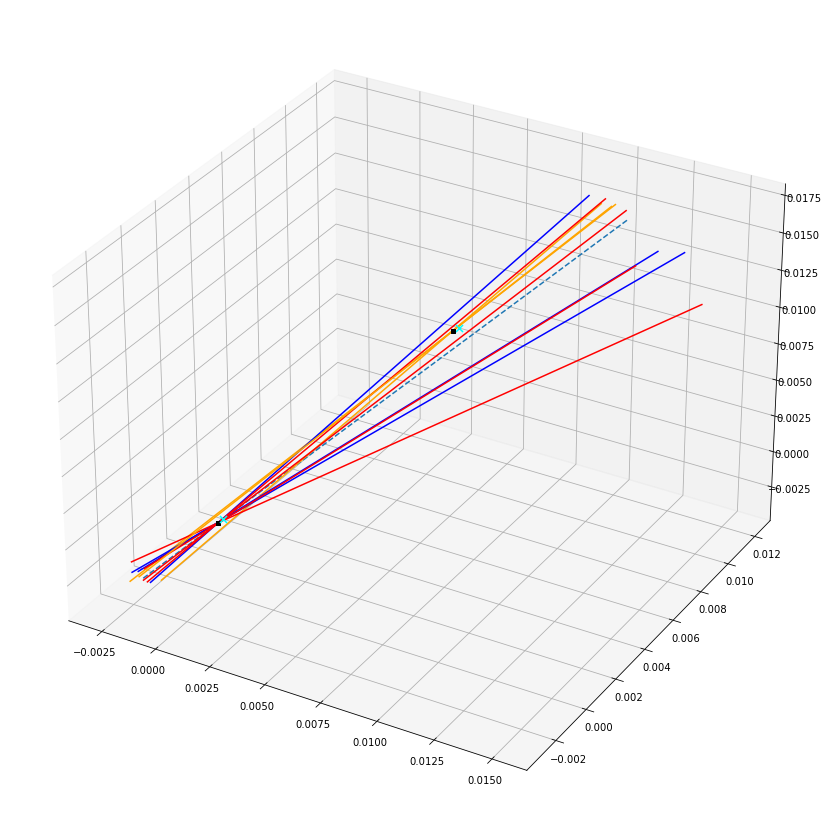

In [115]:
%matplotlib inline
goodindex = 13568
badindex = 1618

zoom = [-0.001,0.004]
#print("good")
jet_tracks, true_vertices, rec_vertices = from_index_extract_tracks_and_vertices(badindex,X_allfeatures,y_test,results)
plot_jet(jet_tracks, true_vertices, rec_vertices,[-0.0001,0.003],'./bad-recon-jet.png')
#print("bad")


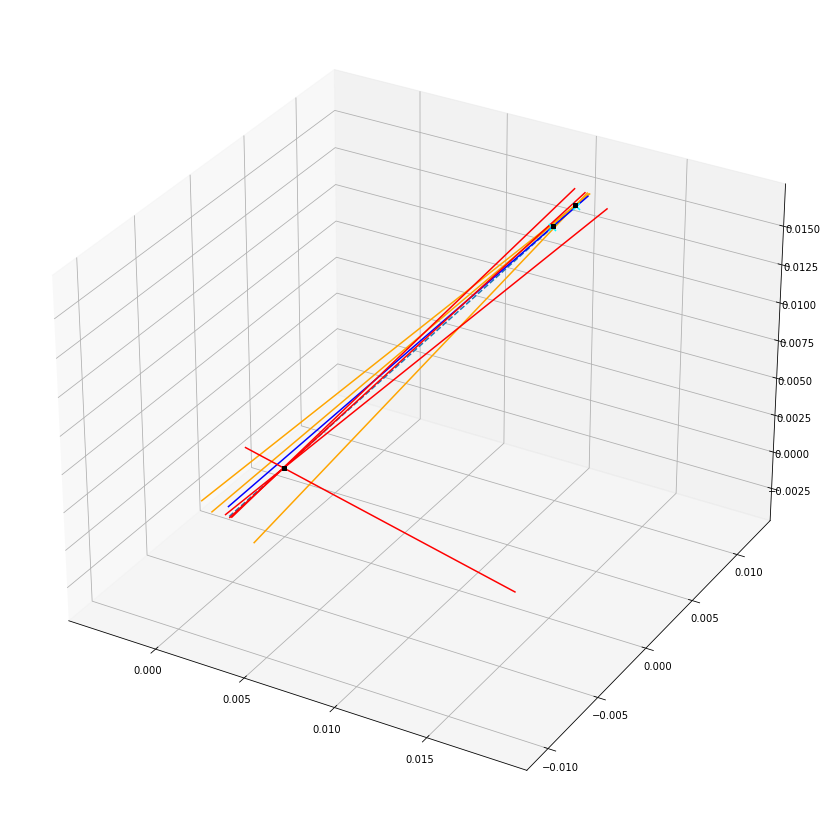

In [116]:
%matplotlib inline
goodindex = 13568
badindex = 1618

zoom = [-0.001,0.004]
#print("good")
jet_tracks, true_vertices, rec_vertices = from_index_extract_tracks_and_vertices(goodindex,X_allfeatures,y_test,results)
plot_jet(jet_tracks, true_vertices, rec_vertices,[-0.0001,0.003],'good-recon-jet.png')
#print("bad")

In [46]:
np.sum(bjets_DF[['secVtx_x']].values == 3.809397e-08)

0

In [47]:
np.where(bjets_DF['secVtx_x']*1000 <1e-4)

(array([  6585,  18381,  18797,  44206,  48899,  69575,  74132,  78157,
        107339, 107842, 111858, 114957, 138364, 142024, 143960, 173584,
        176720, 188090, 199024, 203464, 225767, 236039, 237000, 240064,
        248573, 253753, 258604, 259071, 261706, 268979], dtype=int64),)

In [48]:
bjets_DF['secVtx_x'][np.where(bjets_DF['secVtx_x']*1000 <1e-4)[0]]

6585      6.105777e-08
18381     3.920804e-08
18797     9.103908e-08
44206     5.080844e-08
48899     1.368541e-08
69575     7.085774e-08
74132     1.506676e-08
78157     8.493033e-09
107339    3.432485e-08
107842    6.460691e-08
111858    8.489323e-08
114957    3.752381e-08
138364    8.553804e-09
142024    1.122756e-08
143960    1.749967e-08
173584    5.628608e-08
176720    9.309272e-08
188090    2.651544e-08
199024    1.610361e-08
203464    8.138728e-08
225767    9.221448e-08
236039    9.895872e-08
237000    9.826714e-08
240064    5.417566e-08
248573    8.348949e-08
253753    3.393136e-08
258604    8.999544e-09
259071    3.809397e-08
261706    4.735753e-08
268979    8.551888e-08
Name: secVtx_x, dtype: float64

In [49]:
bjets_DF.iloc[259071]['tracks']

[[1.628684627349816e-05,
  2.0908664678629624e-05,
  0.6775763297695994,
  0.8408847915056228,
  8.761524238250263e-05,
  3.809396846516223e-08,
  3.809396846516223e-08,
  5.3873006848045414e-08,
  -1.4860394327701483e-05,
  6.665586392942373e-06,
  2.0908664678629624e-05],
 [3.6330471728799713e-06,
  6.813346463192597e-06,
  0.8467287943716347,
  0.7036994236032967,
  0.0007668415112193433,
  3.809396846516223e-08,
  3.809396846516223e-08,
  5.3873006848045414e-08,
  3.535381583741049e-06,
  8.367250550304937e-07,
  6.813346463192597e-06],
 [1.1998320966736807e-05,
  1.0825182140350386e-05,
  0.7547829899232071,
  0.9313772045580506,
  0.00013737652800886458,
  3.809396846516223e-08,
  3.809396846516223e-08,
  5.3873006848045414e-08,
  -1.0466583893722031e-05,
  -5.866031675376007e-06,
  1.0825182140350386e-05],
 [0.0005019159405211561,
  -0.0003737604412327477,
  0.8011295666381338,
  0.6992972433203719,
  5.099752897477801e-05,
  0.006063750480215479,
  0.006605323558188895,
  0.009

In [50]:
%matplotlib inline

jet_tracks, true_vertices, rec_vertices = from_index_extract_tracks_and_vertices(badindex, split,trks,bjets_DF,results)
plot_jet(jet_tracks, true_vertices, rec_vertices,[-0.001,0.005])

NameError: name 'split' is not defined

In [ ]:
print(bjets_DF.iloc[goodindex+split])
print("\nand the bad\n")
print(bjets_DF.iloc[badindex+split])


In [ ]:
mean_err_per_jet[bad_maes]

In [ ]:
bad_maes

In [ ]:
np.where(mean_err_per_jet[good_maes]>100.)


In [ ]:
good_maes[0][96]

In [ ]:
mean_err_per_jet[15683]

In [ ]:
def my_dummy_func(blabla):
    blabla += 1
    return sec_dummy_func(blabla)
    
def sec_dummy_func(blabla2):
    if blabla2 == 1:
        boolean = False
        integer = 1
        return boolean, integer
    else:
        boolean = True
        integer = 2
        return boolean

In [ ]:
my_dummy_func(0)

In [ ]:
my_dummy_func(2)

### Impact of Tracks in a Jet

Use this "bootstrap" method. Remove a single track from a jet and use the RNN to predict on this new jet. Observe the new values of mean Abs err and mean % err. Loop through tracks in the jet and see if removing tracks can improve performance.

In [ ]:
def plot_mpes_and_maes(x,y1,y2, title, ignore_dir, rescale = 1):
    width = 0.35       # the width of the bars
    if ignore_dir:
        x=x[1:]
        y1=y1[1:]
        y2=y2[1:]
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    rects1 = ax.bar(x, rescale*np.array(y1), width, color='royalblue')

    rects2 = ax.bar(x+width, y2, width, color='seagreen')

    # add some
    ax.set_ylabel('Errors')
    ax.set_xlabel('Removed Track')
    ax.set_title(title)
    #ax.set_xticks(x + width / 2)
    ax.legend( (rects1[0], rects2[0]), ('Sec Vtx', 'Ter Vtx') )

    plt.show()

Now select a jet and calculate the delta errors for each track removal

In [ ]:
jet_index = actual_ind
jet_index = 8765

In [ ]:
jet_copy = copy.copy(X_test[jet_index])
original_prediction = myRNN.predict(np.array([jet_copy]))
true_values = y_test[jet_index]

original_abs_err = abs(original_prediction - true_values)
original_mae = np.mean(original_abs_err)
original_mpe = np.mean(100*original_abs_err/true_values)

#for sec and ter vtx separately
original_sec_mae = np.mean(original_abs_err[0,0:3])
original_ter_mae = np.mean(original_abs_err[0,3:6])
original_sec_mpe = np.mean((100*original_abs_err/true_values)[0,0:3])
original_ter_mpe = np.mean((100*original_abs_err/true_values)[0,3:6])

# find the first null track, as dif n of tracks in each jet
for i in range(30):
    if not np.any(jet_copy[i]):
        null_trk_index = i
        break

print(null_trk_index)

# now to delete the jth track and add a null track at the end of the track_collection
# to ensure there are still 30 tracks
maes=[]
mpes=[]
sec_dmaes=[]
sec_dmpes=[]
ter_dmaes=[]
ter_dmpes=[]
for j in range(null_trk_index):
    actual_tracks = jet_copy[0:null_trk_index]
    jet_minus_trk=np.zeros((30,5))
    jet_minus_trk[0:null_trk_index-1] = np.delete(actual_tracks,j,0) # deletes the jth track
    new_prediction = myRNN.predict(np.array([jet_minus_trk]))
    new_abs_err = abs(new_prediction - true_values)
    new_mae = np.mean(new_abs_err)
    new_mpe = np.mean(100*new_abs_err/true_values)
    #print("delta MAE = "+str(new_mae-original_mae)+" (delta MPE = "+str(new_mpe-original_mpe)+")")
    maes.append(new_mae-original_mae)
    mpes.append(new_mpe-original_mpe)
    #print(abs(new_prediction-true_values)/true_values)
    
    #calculate delta err for sec and ter vertices separately
    new_sec_mae = np.mean(new_abs_err[0,0:3])
    new_ter_mae = np.mean(new_abs_err[0,3:6])
    new_sec_mpe = np.mean((100*new_abs_err/true_values)[0,0:3])
    new_ter_mpe = np.mean((100*new_abs_err/true_values)[0,3:6])

    sec_dmaes.append(new_sec_mae - original_sec_mae)
    ter_dmaes.append(new_ter_mae - original_ter_mae)
    sec_dmpes.append(new_sec_mpe - original_sec_mpe)
    ter_dmpes.append(new_ter_mpe - original_ter_mpe)

t = np.linspace(1,null_trk_index,null_trk_index)
plot_mpes_and_maes(t, sec_dmaes, ter_dmaes, "delta abs err", ignore_dir = False)
plot_mpes_and_maes(t, sec_dmpes, ter_dmpes, "delta % err", ignore_dir = False)

In [ ]:
print(mae_per_jet[jet_index])
percentage_errs[jet_index]

In [ ]:
bjets_DF.iloc[280000+jet_index]
# both i=2 and 3 are large IP tracks, both tertiary tracks but affect prediction of sec and ter vtx

In [ ]:
tes=np.array([jet_copy])
tes2=tes[:,:11]
np.random.shuffle(tes2[0])
tes[:,:11]=tes2
myRNN.predict(tes)

In [ ]:
myRNN.predict(np.array([jet_copy]))

In [ ]:
myRNN.predict(np.zeros((1,30,5)))

Maybe if I looked into histograming the above sec_maes. Problem is for one jet theres not really enough statistics, you'd need to do it across jets, but then have to account for confounders, treat them as nuisance params and integrate out. E.g. momentum, decay position etc. Bring in the fact that % and abs are dif

### Error Change as tracks added

Idea is to plot the MAE and MPE of a jet adding in each track one by one. So start with all null tracks, then add track 1 (the direction), track 2, track 3, ...
Look at the curve MAE, look for changes.
Again do for sec and ter vtx separately.

In [ ]:
jet_copy = copy.copy(X_test[jet_index])
true_values = y_test[jet_index]

#for sec and ter vtx separately
blank_jet = np.zeros((1,30,5))

blank_prediction = myRNN.predict(blank_jet)

blank_abs_err = abs(blank_prediction - true_values)
blank_mae = np.mean(blank_abs_err)
blank_mpe = np.mean(100*blank_abs_err/true_values)


blank_sec_mae = np.mean(blank_abs_err[0,0:3])
blank_ter_mae = np.mean(blank_abs_err[0,3:6])
blank_sec_mpe = np.mean((100*blank_abs_err/true_values)[0,0:3])
blank_ter_mpe = np.mean((100*blank_abs_err/true_values)[0,3:6])

sec_maes=[blank_sec_mae]
sec_mpes=[blank_sec_mpe]
ter_maes=[blank_ter_mae]
ter_mpes=[blank_ter_mpe]

for i in range((null_trk_index)):
    blank_jet[0,i] = jet_copy[i]
    
    new_prediction = myRNN.predict(blank_jet)
    new_abs_err = abs(new_prediction - true_values)
    new_mae = np.mean(new_abs_err)
    new_mpe = np.mean(100*new_abs_err/true_values)
    
    #calculate delta err for sec and ter vertices separately
    new_sec_mae = np.mean(new_abs_err[0,0:3])
    new_ter_mae = np.mean(new_abs_err[0,3:6])
    new_sec_mpe = np.mean((100*new_abs_err/true_values)[0,0:3])
    new_ter_mpe = np.mean((100*new_abs_err/true_values)[0,3:6])
    
    sec_maes.append(new_sec_mae)
    sec_mpes.append(new_sec_mpe)
    ter_maes.append(new_ter_mae)
    ter_mpes.append(new_ter_mpe)

In [ ]:
trk_n = np.linspace(0,null_trk_index,null_trk_index+1)
plt.plot(trk_n, sec_maes, label ='sec')
plt.plot(trk_n, ter_maes, label ='ter')
plt.legend()
plt.minorticks_on()
plt.grid(which='both')
plt.show()
plt.plot(trk_n, sec_mpes, label ='sec')
plt.plot(trk_n, ter_mpes, label='ter')
plt.legend()
plt.show()

### Plot of errors for each value

Plots all the individual (secondary x, secondary y, secondary z, tertiary x...) % errors, the distribution looks gaussian with a very long tail

In [ ]:
percerrs=percentage_errs.reshape(120000)# plot distribution of mean errs per jet

plt.hist((percerrs), bins=np.linspace(0,50,100))#90,100,200,300,400,500,600,700,800,900])
plt.xlabel('% errors in sec and ter xyz')

#plt.hist((meanerrs), bins=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])


In [ ]:
mean_perc_err_per_jet=np.mean(percentage_errs,axis=1)

In [ ]:
print(np.median(mae_per_jet)) # median error is 7% that's actually not too bad considering gauss err of 1% on 5 params (ish)
print(np.mean(mae_per_jet)) # mean and median very different

### Errors against Sec Vtx Displacement

Look at the percentage and absolute errors of jets in two regions. Regions separated by the absolute displacement of secondary (and tertiary) vertex, ds. Find a phase behaviour transition arond ds=1mm

In [ ]:
y_test[:,:3]

In [ ]:
# separate out large ds jets
tervtx_cond = np.linalg.norm(y_test[:,3:],axis=1) > 2
secvtx_cond = np.linalg.norm(y_test[:,:3],axis=1) > 2
large_displaced_bs_indices= np.where(secvtx_cond & tervtx_cond)[0]
print("large ds mean % err",np.mean(percentage_errs[large_displaced_bs_indices]))
# so for jets where both sec and ter vtx are more than 1mm displaced, the percentage error is average 3% (and median 2%)
large_ds_perc_errs = np.mean(percentage_errs[large_displaced_bs_indices],axis=1)
large_ds_maes = mae_per_jet[large_displaced_bs_indices]


# now do same for small ds jets
tervtx_cond = np.linalg.norm(y_test[:,3:],axis=1) < 2
secvtx_cond = np.linalg.norm(y_test[:,:3],axis=1) < 2
small_displaced_bs_indices= np.where(secvtx_cond & tervtx_cond)[0]
print("small ds mean % err",np.mean(percentage_errs[small_displaced_bs_indices]))
small_ds_perc_errs = np.mean(percentage_errs[small_displaced_bs_indices],axis=1)
small_ds_maes = mae_per_jet[small_displaced_bs_indices]

In [ ]:
np.median(np.linalg.norm(y_test[:,3:],axis=1))

In [ ]:
np.median(np.linalg.norm(y_test[:,:3],axis=1))

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(10,8))

axs[0, 0].hist(large_ds_perc_errs,np.linspace(0,100,100))
axs[0, 0].set_ylabel('N ds>1mm jets')

axs[0, 1].hist(large_ds_maes,bins=np.linspace(0,1,100))

axs[1, 0].hist(small_ds_perc_errs,np.linspace(0,100,100))
axs[1, 0].set_xlabel('Mean % Error')
axs[1, 0].set_ylabel('N ds<1mm jets')

axs[1, 1].hist(small_ds_maes,bins=np.linspace(0,1,100))
axs[1, 1].set_xlabel('Mean Abs Error (mm)')


Look at one of the outlier cases, a large ds with the largest percentage error

In [ ]:
print(np.argmax(np.mean(percentage_errs[large_displaced_bs_indices],axis=1)))
argmaxind = np.argmax(np.mean(percentage_errs[large_displaced_bs_indices],axis=1))
actual_ind = large_displaced_bs_indices[argmaxind]
np.sqrt(bjets_DF.iloc[split+actual_ind]['secVtx_x']**2 + bjets_DF.iloc[split+actual_ind]['secVtx_y']**2 + bjets_DF.iloc[split+actual_ind]['secVtx_z']**2)
#np.linalg.norm(bjets_DF.iloc[split+1853]['secVtx_x','secVtx_y','secVtx_z'],axis=1)

In [ ]:
def get_secter_tracks(bjets_DF):
    ntracks = 10
    all_features = np.array(['d0', 'z0', 'phi', 'theta', 'q/p', 'x_o', 'y_o', 'z_o', 'x_p', 'y_p', 'z_p'])
    nfeatures = len(all_features)
    trks = np.zeros((len(bjets_DF), ntracks, nfeatures))
    for i in range(len(bjets_DF)):
        trks[i] = np.array([bjets_DF['tracks'][i]])[:, :, :]

### Old Vertexing Efficiency

Define a found vertex when a reconstructed vertex is within a specified tolerance distance of a true vertex. This tolerance is based off of the errors added at simulation level. So as a first estimate take if its within 5 sigma. Need to do some error analysis do this properly...

Make a very basic guess. Errors in theta, phi propagate as sigma x ds (ds is vtx displacement). IP errors propagate simply. So add all together it would be (sigma_ip + ds x sigma_ang) (careful with units). ds ranges between 1-10mm.
so error is approx (1.01 x sigma)m (as sigma_ip = sigma m, sigma_ang = sigma rad).

Remember to apply in the longitudinal and transverse directions separately. So calculate error in xy and error in z separately.

In [ ]:
reconstructed_vertices = results.reshape(40000,3)

In [ ]:
true_vertices = y_test.reshape(40000,3)

In [ ]:
err_in_z = (reconstructed_vertices-true_vertices)[:,2]
len(np.where(abs(err_in_z) < .05)[0])

As an initial estimate 16316/40000 (40.8%) vertices found using only criteria on the z, i.e. err_z < 0.05mm (5x10^-5 = 5xsigma_z)
But need to factor in the xy condition as well.

In [ ]:
x_x0 = (reconstructed_vertices-true_vertices)[:,0]
y_y0 = (reconstructed_vertices-true_vertices)[:,1]
err_in_xy = np.sqrt((x_x0)**2 + (y_y0)**2)
len(np.where(err_in_xy < .05)[0])

So a lot less pass the xy condition then the z condition. Only 14208/40000 (35.5%).

In [ ]:
len(np.where((err_in_xy < .05) & (abs(err_in_z) < .05))[0])

So 13087/40000 (32.7%) vertices found.

In [ ]:
len(np.where(err_in_xy + abs(err_in_z) < 0.1)[0])

In [ ]:
plt.hist(err_in_z,bins=np.linspace(-2,2,200))
plt.show()

In [ ]:
from scipy.stats import norm, cauchy
from sklearn.mixture import GaussianMixture

import matplotlib.mlab as mlab

In [ ]:
plt.figure(figsize=(10,8))
# best fit of data
(mu, sigma) = cauchy.fit(err_in_z)

# the histogram of the data
n, bins, patches = plt.hist(err_in_z, bins=np.linspace(-2,2,200),normed=1, facecolor='green', alpha=0.75)

# add a 'best fit' line
y = cauchy.pdf( bins,mu, sigma)
l = plt.plot(bins, y, 'r--', label='lorentzian fit',linewidth=2)
plt.xlabel('error in z')
plt.ylabel('Normed Count')
plt.title(r'$\mathrm{Error\ in\ z\ for\ 1mm\ sample:\:}\ \mu=%.3f mm,\ \sigma=%.3f mm$' %(mu, sigma))
plt.grid(True)
plt.legend()

print(mu)
print(sigma)

In [ ]:
plt.figure(figsize=(10,8))
# best fit of data
(mu, sigma) = norm.fit(err_in_z[abs(err_in_z)<.2])

# the histogram of the data
n, bins, patches = plt.hist(err_in_z, bins=np.linspace(-2,2,300),normed=1, facecolor='green', alpha=0.75)

# add a 'best fit' line
y = norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', label='gaussian fit',linewidth=2)
plt.xlabel('error in z')
plt.ylabel('Normed Count')
plt.title(r'$\mathrm{Error\ in\ z\ for\ 0.1mm\ sample:\:}\ \mu=%.3f mm,\ \sigma=%.3f mm$' %(mu, sigma))
plt.grid(True)
plt.legend()

print(mu)
print(sigma)

In [ ]:
plt.figure(figsize=(10,8))
# best fit of data
gmm = GaussianMixture(n_components=2)
gmm.fit(err_in_z.reshape(-1,1))
mu1 = gmm.means_[0, 0]
mu2 = gmm.means_[1, 0]
var1, var2 = gmm.covariances_
wgt1, wgt2 = gmm.weights_

print(var1[0])
print(var2[0])

# the histogram of the data
n, bins, patches = plt.hist(err_in_z, bins=np.linspace(-2,2,300),normed=1, facecolor='green', alpha=0.75)

# add a 'best fit' line
y = norm.pdf( bins, mu2, var2[0])
#l = plt.plot(bins, y, 'r--', label='gaussian fit',linewidth=2)
plt.plot(bins, norm.pdf(bins, mu1, np.sqrt(var1)).reshape(300))
plt.plot(bins, norm.pdf(bins, mu2, np.sqrt(var2)).reshape(300),'r')
#plt.plot(bins, norm.pdf(bins, mu1, np.sqrt(var1)).reshape(300)+norm.pdf(bins, mu2, np.sqrt(var2)).reshape(300))
plt.xlabel('error in z')
plt.ylabel('Normed Count')
plt.title(r'$\mathrm{Error\ in\ z\ for\ 0.1mm\ sample:\:}\ \mu1=%.3f mm,\ \sigma1=%.3f mm$' %(mu1, np.sqrt(var1[0])))
plt.grid(True)
plt.legend()

print(mu)
print(sigma)

In [ ]:
err_in_z[abs(err_in_z)<3]

In [ ]:
def K(phi,theta):
    denominator=np.sqrt((1/np.tan(theta)-np.sqrt(2)*np.sin(phi))**2 + (1/np.tan(theta)-np.sqrt(2)*np.cos(phi))**2 + (np.sin(phi)-np.cos(phi))**2)
    return 1/denominator

def B(phi,theta):
    return K(phi,theta)*(np.sin(phi)-np.cos(phi))

def A(phi,theta,phi_p):
    numerator=np.cos(phi_p)*(1/np.tan(theta)-np.sqrt(2)*np.sin(phi)) - np.sin(phi_p)*(1/np.tan(theta)-np.sqrt(2)*np.cos(phi))
    return K(phi,theta)*numerator

def dmin(d_0,z_0,phi,theta,phi_p):
    return abs(d0*A(phi,theta,phi_p) + z0*B(phi,theta))


In [ ]:
phi = np.linspace(0,2*np.pi,1000)
theta = np.pi/4
phi_p=52*(np.pi/180)
d0=1
z0=1

In [ ]:
plt.plot(phi,B(phi,theta))

In [ ]:
1/np.tan(np.array([np.pi/3,np.pi*2/3]))